# Parse protein complexes from datasets and count the number of nodes/edges, and atoms. 

Then filter out complexes with too many atoms


In [1]:
from rdkit import Chem
from transformers import T5Tokenizer, T5EncoderModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import os
import json
import pickle
from pprint import pprint
import argparse

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import dgl

import torchmetrics

from train import *

In [2]:
from tqdm import tqdm

In [3]:
dataset_name = 'ProtCID'
# data_dir = '/home/ec2-user/SageMaker/efs/data/ProtCID/JaredJanssen_Benchmark_thres_10'
data_dir = '/home/ec2-user/SageMaker/efs/data/ProtCID/JaredJanssen_Benchmark_thres_6'
input_type = 'complex'
# data_dir = '/home/ec2-user/SageMaker/efs/data/PIGNet/data/pdbbind_v2019/scoring'
residue_featurizer_name = 'MACCS'
# residue_featurizer_name = 'gin-supervised-contextpred-mean'
use_energy_decoder = True
# data_suffix='small'
data_suffix='full'

In [4]:
train_df = pd.read_csv(
    os.path.join(data_dir, f"train_{data_suffix}.csv")
)
test_df = pd.read_csv(
    os.path.join(data_dir, f"test_{data_suffix}.csv")
)
print(train_df.shape, test_df.shape)

(16391, 14) (4055, 14)


In [5]:
from Bio.PDB import MMCIFParser, PDBParser
from Bio.PDB.Polypeptide import three_to_one, is_aa
from ppi.data_utils import parse_structure, residue_to_mol
from ppi.data_utils import mol_to_feature

# try parsing all the cropped PDB
pdb_parser = PDBParser(
    QUIET=True,
    PERMISSIVE=True,
)
cif_parser = MMCIFParser(QUIET=True)

In [6]:
residue_featurizer = get_residue_featurizer(residue_featurizer_name)
featurizer = NoncanonicalComplexFeaturizer(
    residue_featurizer,
    count_atoms=True,
    top_k=30,
)

In [7]:
row = train_df.iloc[0]

In [8]:
train_df.head()

,id,label,complex_type,pdb_file,UnpID,PdbID,InterfaceID,seq-A,seq-B,cluster_center-A,cluster_center-B,receptor_chain_id,ligand_chain_id,has_crop_error
0,CAPP1_MAIZE_6u2t_4,1,homo,physiol/physiol_pdb/homo/CAPP1_MAIZE_6u2t_4.pdb,CAPP1_MAIZE,6u2t,4,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...,KHHSIDAQLRQLVPGKVSEDDKLIEYDALLVDRFLNILQDLHGPSL...,CAPP1_MAIZE_6mgi_4-A,CAPP1_MAIZE_6mgi_4-A,A,B,False
1,DPOLL_HUMAN_5iio_6,1,homo,physiol/physiol_pdb/homo/DPOLL_HUMAN_5iio_6.pdb,DPOLL_HUMAN,5iio,6,NHNLHITEKLEVLAKAYSVQGDKWRALGYAKAINALKSFHKPVTSY...,TNHNLHITEKLEVLAKAYSVQGDKWRALGYAKAINALKSFHKPVTS...,DPOLL_HUMAN_5iio_3-A,DPOLL_HUMAN_5iio_3-A,A,B,False
2,CNNM3_HUMAN_6wur_4,1,homo,physiol/physiol_pdb/homo/CNNM3_HUMAN_6wur_4.pdb,CNNM3_HUMAN,6wur,4,GPLNMIQGVLELRCRTVEDVLTPLEDCFMLDASTVLDFGVLASIMQ...,GPLNMIQGVLELRCRTVEDVLTPLEDCFMLDASTVLDFGVLASIMQ...,CNNM2_MOUSE_5mmz_6-A,CNNM2_MOUSE_5mmz_6-A,A,B,False
3,FA7_HUMAN_6r2w_8,1,homo,physiol/physiol_pdb/homo/FA7_HUMAN_6r2w_8.pdb,FA7_HUMAN,6r2w,8,ANAFLXXLRPGSLXRXCKXXQCSFXXARXIFKDAXRTKLFWISYSD...,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,FA9_HUMAN_1edm_4-A,1jbu-X-H|COAGULATION,A,B,False
4,CCL2_HUMAN_1dok_4,1,homo,physiol/physiol_pdb/homo/CCL2_HUMAN_1dok_4.pdb,CCL2_HUMAN,1dok,4,MQPDAINAPVTCCYNFTNRKISVQRLASYRRITSSKCPKEAVIFKT...,MQPDAINAPVTCCYNFTNRKISVQRLASYRRITSSKCPKEAVIFKT...,2mpm-B-A|Eotaxin|CCR3|GPASVPTTCC[...],2mpm-B-A|Eotaxin|CCR3|GPASVPTTCC[...],A,B,False


In [ ]:
stats = []
for i in tqdm(range(len(train_df))):
    row = train_df.iloc[i]
    structure = parse_structure(
        pdb_parser,
        cif_parser,
        name='name',
        file_path=os.path.join(data_dir, row["pdb_file"]),
    )
    for chain in structure.get_chains():
        if chain.id == row["receptor_chain_id"]:
            protein = chain
        elif chain.id == row["ligand_chain_id"]:
            ligand = chain

    sample = featurizer.featurize(
        {"ligand": ligand, "protein": protein}
    )
    g = sample['graph']
    
    target_n_atoms = g.ndata['atom_counts'][g.ndata['mask'] == 1].sum().item()
    ligand_n_atoms = g.ndata['atom_counts'][g.ndata['mask'] == 0].sum().item()

    ligand_mol = residue_to_mol(ligand)
    target_mol = residue_to_mol(protein)
    ligand_mol = Chem.RemoveHs(ligand_mol)
    target_mol = Chem.RemoveHs(target_mol)
    
    assert target_n_atoms == target_mol.GetNumAtoms()
    assert ligand_n_atoms == ligand_mol.GetNumAtoms()
    
    datum_stats = {
        'id': row.id,
        'n_nodes': g.num_nodes(),
        'n_edges': g.num_edges(),
        'target_n_atoms': g.ndata['atom_counts'][g.ndata['mask'] == 1].sum().item(),
        'ligand_n_atoms': g.ndata['atom_counts'][g.ndata['mask'] == 0].sum().item(),
    }
    stats.append(datum_stats)

  5%|▌         | 859/16391 [00:31<09:12, 28.11it/s]

In [10]:
stats = pd.DataFrame(stats)
stats['interaction_mat_shape'] = stats['target_n_atoms'] * stats['ligand_n_atoms']
print(stats.shape)
stats.head()

(16391, 6)


,id,n_nodes,n_edges,target_n_atoms,ligand_n_atoms,interaction_mat_shape
0,CAPP1_MAIZE_6u2t_4,32,960,124,124,15376
1,DPOLL_HUMAN_5iio_6,8,64,36,36,1296
2,CNNM3_HUMAN_6wur_4,32,960,127,127,16129
3,FA7_HUMAN_6r2w_8,5,25,20,13,260
4,CCL2_HUMAN_1dok_4,11,121,48,54,2592


In [11]:
stats.describe()

,n_nodes,n_edges,target_n_atoms,ligand_n_atoms,interaction_mat_shape
count,16391.000000,16391.000000,16391.000000,16391.000000,1.639100e+04
mean,26.184919,653.686718,100.670124,100.320237,2.057545e+04
std,27.843059,895.670136,103.391730,103.148374,6.449505e+04
min,2.000000,4.000000,6.000000,6.000000,3.600000e+01
25%,11.000000,121.000000,41.000000,41.000000,1.677000e+03
50%,17.000000,289.000000,66.000000,66.000000,4.292000e+03
75%,32.000000,960.000000,122.000000,121.000000,1.464100e+04
max,939.000000,28170.000000,1413.000000,1439.000000,1.996569e+06


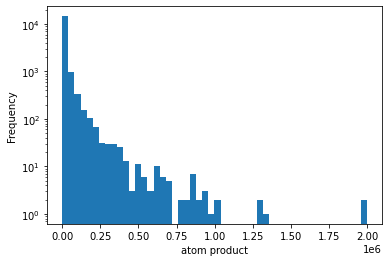

In [12]:
ax = stats['interaction_mat_shape']\
    .plot(kind='hist', bins=50, log=True);
ax.set(xlabel='atom product');

In [13]:
train_df = train_df.set_index('id')
train_df = train_df.merge(
    stats.set_index('id')[['interaction_mat_shape']],
    left_index=True,
    right_index=True
)

In [14]:
train_df.shape

(16391, 14)

In [15]:
# mask = train_df['interaction_mat_shape'] < 1e6
mask = train_df['interaction_mat_shape'] < 1e5
print(train_df.loc[mask].shape)
train_df.loc[mask].to_csv(
    os.path.join(data_dir, f'train_{data_suffix}_filt1e5.csv')
)

(15736, 14)


In [16]:
stats = []
for i in tqdm(range(len(test_df))):
    row = test_df.iloc[i]
    structure = parse_structure(
        pdb_parser,
        cif_parser,
        name='name',
        file_path=os.path.join(data_dir, row["pdb_file"]),
    )
    for chain in structure.get_chains():
        if chain.id == row["receptor_chain_id"]:
            protein = chain
        elif chain.id == row["ligand_chain_id"]:
            ligand = chain

    sample = featurizer.featurize(
        {"ligand": ligand, "protein": protein}
    )
    g = sample['graph']
    
    target_n_atoms = g.ndata['atom_counts'][g.ndata['mask'] == 1].sum().item()
    ligand_n_atoms = g.ndata['atom_counts'][g.ndata['mask'] == 0].sum().item()

    ligand_mol = residue_to_mol(ligand)
    target_mol = residue_to_mol(protein)
    ligand_mol = Chem.RemoveHs(ligand_mol)
    target_mol = Chem.RemoveHs(target_mol)
    
    assert target_n_atoms == target_mol.GetNumAtoms()
    assert ligand_n_atoms == ligand_mol.GetNumAtoms()
    
    datum_stats = {
        'id': row.id,
        'n_nodes': g.num_nodes(),
        'n_edges': g.num_edges(),
        'target_n_atoms': g.ndata['atom_counts'][g.ndata['mask'] == 1].sum().item(),
        'ligand_n_atoms': g.ndata['atom_counts'][g.ndata['mask'] == 0].sum().item(),
    }
    stats.append(datum_stats)

100%|██████████| 4055/4055 [02:14<00:00, 30.10it/s]


In [17]:
stats = pd.DataFrame(stats)
stats['interaction_mat_shape'] = stats['target_n_atoms'] * stats['ligand_n_atoms']
print(stats.shape)
stats.describe()

(4055, 6)


,n_nodes,n_edges,target_n_atoms,ligand_n_atoms,interaction_mat_shape
count,4055.000000,4055.000000,4055.000000,4055.000000,4.055000e+03
mean,26.392109,658.972380,102.103329,101.365228,2.243410e+04
std,28.353530,910.603155,110.973874,110.232928,9.081825e+04
min,2.000000,4.000000,6.000000,6.000000,3.600000e+01
25%,11.000000,121.000000,42.000000,41.000000,1.749000e+03
50%,17.000000,289.000000,68.000000,66.000000,4.356000e+03
75%,32.000000,960.000000,122.000000,121.000000,1.475600e+04
max,386.000000,11580.000000,1545.000000,1541.000000,2.380845e+06


In [18]:
test_df = test_df.set_index('id')
test_df = test_df.merge(
    stats.set_index('id')[['interaction_mat_shape']],
    left_index=True,
    right_index=True
)

In [19]:
# mask = test_df['interaction_mat_shape'] < 1e6
mask = test_df['interaction_mat_shape'] < 1e5
print(test_df.loc[mask].shape)
test_df.loc[mask].to_csv(
    os.path.join(data_dir, f'test_{data_suffix}_filt1e5.csv')
)

(3889, 14)
